In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:

# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:

# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
import datetime as dt
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
start_date = '2016-08-23'
end_date = '2017-08-23'

results = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= start_date, Measurement.date <= end_date)\
    .all()


In [15]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = ["Date", "Precipitation"]
Precp_df = pd.DataFrame(results, columns=column_names)

# Sort the DataFrame by date
Precp_df = Precp_df.sort_values(by='Date')

print(Precp_df)

            Date  Precipitation
0     2016-08-23           0.00
1009  2016-08-23            NaN
1529  2016-08-23           1.79
704   2016-08-23           0.05
361   2016-08-23           0.15
...          ...            ...
1527  2017-08-22           0.00
1008  2017-08-23           0.00
360   2017-08-23           0.00
1528  2017-08-23           0.08
2229  2017-08-23           0.45

[2230 rows x 2 columns]


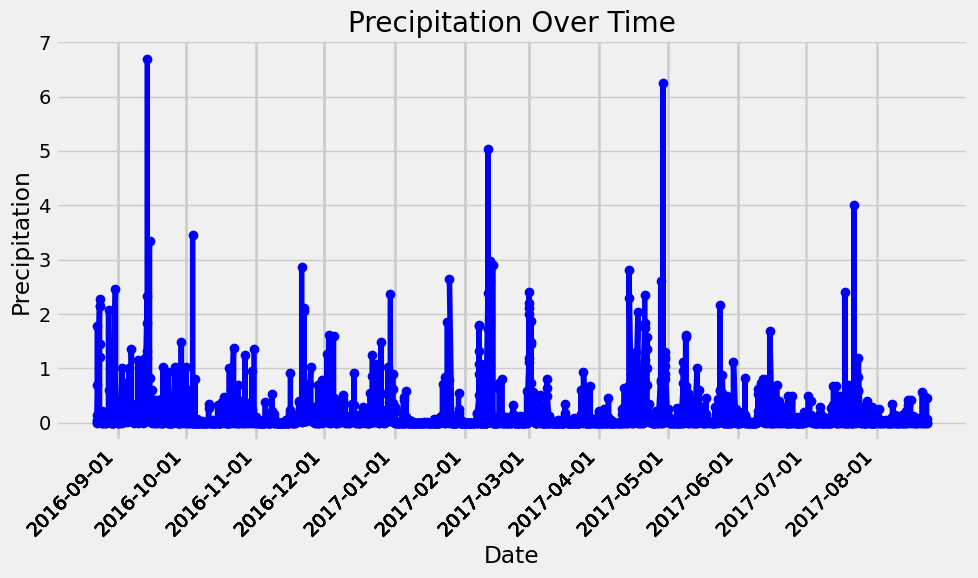

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
# Plotting the data
Precp_df['Date'] = pd.to_datetime(Precp_df['Date'])

# Sort the DataFrame by date
Precp_df = Precp_df.sort_values(by='Date')

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(Precp_df['Date'], Precp_df['Precipitation'], marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation Over Time')

# Label x-axis on the first day of each month
plt.xticks(Precp_df['Date'][Precp_df['Date'].dt.day == 1], Precp_df['Date'][Precp_df['Date'].dt.day == 1].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()



In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = Precp_df['Precipitation'].describe()

# Print the summary statistics
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
# Query to calculate the total number of stations
total_stations = session.query(Station).count()

print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id).label('count'))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.id).desc())\
    .all()

# Print the results
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Extract the most active station ID
most_active_station_id = active_stations[0].station

# Query to calculate lowest, highest, and average temperature for the most active station
result = session.query(
    func.min(Measurement.tobs).label('min_temperature'),
    func.max(Measurement.tobs).label('max_temperature'),
    func.avg(Measurement.tobs).label('avg_temperature')
).filter(Measurement.station == most_active_station_id).first()

# Print the results
print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {result.min_temperature}")
print(f"Highest Temperature: {result.max_temperature}")
print(f"Average Temperature: {result.avg_temperature}")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [21]:
# Query the most recent date for the most active station
most_recent_date = session.query(func.max(Measurement.date))\
    .filter(Measurement.station == most_active_station_id)\
    .scalar()

# Print the most recent date
print(f"The most recent date for Station {most_active_station_id}: {most_recent_date}")

The most recent date for Station USC00519281: 2017-08-18


In [22]:
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-18


(54.0, 85.0, 71.66378066378067) Temperature


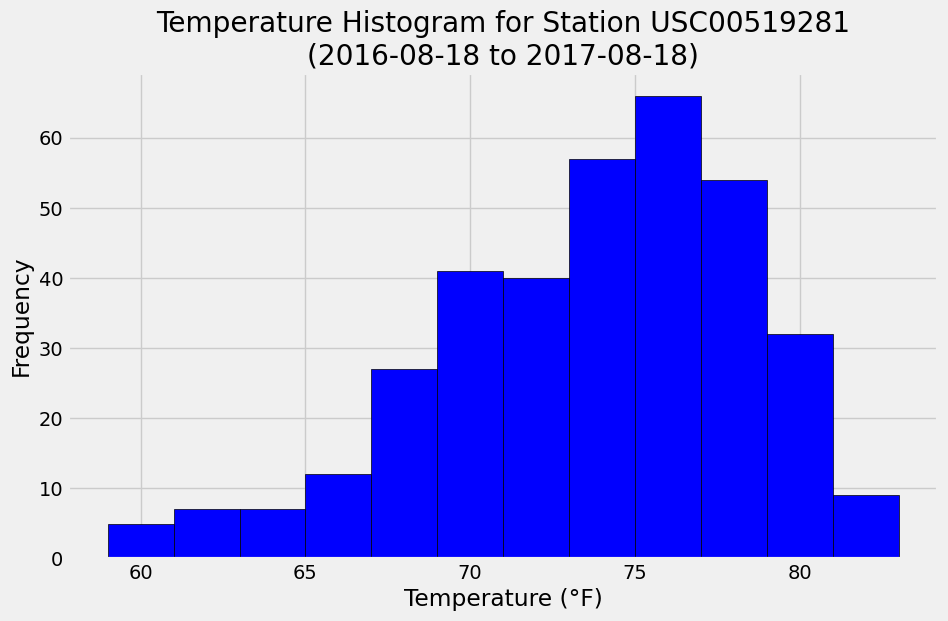

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Extract the most active station ID
most_active_station_id = active_stations[0].station

# Query the last 12 months of temperature observation data for the most active station
start_date = '2016-08-18'
end_date = '2017-08-18'

last_12_months_data = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= start_date, Measurement.date <= end_date)\
    .all()

# Convert the query results to a Pandas DataFrame
Precp_df = pd.DataFrame(last_12_months_data, columns=['Date', 'Temperature'])

print(result, "Temperature")

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(Precp_df['Temperature'], bins=12, color='blue', edgecolor='black')
plt.title(f'Temperature Histogram for Station {most_active_station_id}\n({start_date} to {end_date})')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [24]:
# Close Session
session.close()